In [9]:
import sys
print(sys.executable)


C:\python\python.exe


In [10]:
!C:\python\python.exe -m pip install lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [2]:
!python -m pip install --upgrade pip


  Attempting uninstall: pip
    Found existing installation: pip 21.2.3
    Uninstalling pip-21.2.3:
      Successfully uninstalled pip-21.2.3


In [11]:
!pip install lightgbm matplotlib scikit-learn scipy


In [12]:
import pandas as pd

# Load your CSVs (ensure they're in your working directory)
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
sample_submission = pd.read_csv("sample_submission.csv")


In [13]:
# Filter only non-transferred national holidays
holidays = holidays[(holidays['transferred'] == False) & (holidays['locale'] == 'National')]
holiday_dates = holidays['date'].unique()

# Add holiday flag
train["is_holiday"] = train["date"].isin(holiday_dates).astype(int)
test["is_holiday"] = test["date"].isin(holiday_dates).astype(int)

# Create date-based features
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

train = create_features(train)
test = create_features(test)

# Encode product category
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['family_enc'] = le.fit_transform(train['family'])
test['family_enc'] = le.transform(test['family'])


In [14]:
# Sort for lag calculation
train = train.sort_values(['store_nbr', 'family', 'date'])

# Add lags
train['lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()

# Drop NaNs from lag
train = train.dropna()


In [15]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

features = ['onpromotion', 'is_holiday', 'dayofweek', 'month', 'lag_1', 'rolling_mean_7', 'family_enc']
X = train[features]
y = train['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.1)

model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print("MAE on validation set:", mean_absolute_error(y_val, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 2689572, number of used features: 7
[LightGBM] [Info] Start training from score 361.488613
MAE on validation set: 53.67832482784312


In [16]:
# Fill lag values in test using last values from train
latest = train.groupby(['store_nbr', 'family']).last().reset_index()
test = test.merge(latest[['store_nbr', 'family', 'lag_1', 'rolling_mean_7']], on=['store_nbr', 'family'], how='left')

# Predict
test['sales'] = model.predict(test[features])
submission = test[['id', 'sales']]
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")


✅ submission.csv saved!


In [17]:
import numpy as np
from scipy.stats import norm

def calc_eoq(demand, setup_cost, holding_cost, cv):
    return np.sqrt((2 * demand * setup_cost / holding_cost) * (1 + cv**2 / 2))

def calc_safety_stock(service_level, std_dev, lead_time):
    z = norm.ppf(service_level)
    return z * std_dev * np.sqrt(lead_time)

inventory_plan = []

for (store, family), group in test.groupby(['store_nbr', 'family']):
    predicted_demand = group['sales'].sum()
    std_dev = group['sales'].std() or 1
    eoq = calc_eoq(predicted_demand, setup_cost=100, holding_cost=2, cv=0.3)
    safety = calc_safety_stock(service_level=0.95, std_dev=std_dev, lead_time=7)

    inventory_plan.append({
        'store_nbr': store,
        'family': family,
        'forecasted_demand': round(predicted_demand, 2),
        'EOQ': round(eoq, 2),
        'Safety_Stock': round(safety, 2)
    })

inventory_df = pd.DataFrame(inventory_plan)
inventory_df.to_csv("inventory_plan.csv", index=False)
print("✅ inventory_plan.csv saved!")


✅ inventory_plan.csv saved!


In [18]:
# Step 6: Train model
features = ['onpromotion', 'is_holiday', 'dayofweek', 'month', 'lag_1', 'rolling_mean_7', 'family_enc']
X = train[features]
y = train['sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.1)

model = LGBMRegressor()
model.fit(X_train, y_train)
print(f"Validation MAE: {mean_absolute_error(y_val, model.predict(X_val)):.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 2689572, number of used features: 7
[LightGBM] [Info] Start training from score 361.488613
Validation MAE: 53.68


In [19]:
# Step 7: Align test set
test = test.sort_values(['store_nbr', 'family', 'date'])
# Use last 7 days rolling mean and lag from train
merge_cols = ['store_nbr', 'family']
latest = train.groupby(merge_cols).last().reset_index()
test = test.merge(latest[merge_cols + ['lag_1', 'rolling_mean_7']], on=merge_cols, how='left')

In [21]:
# Get latest known lag features from train
latest_lags = train.groupby(['store_nbr', 'family'])[['lag_1', 'rolling_mean_7']].last().reset_index()

# Merge these into test
test = test.merge(latest_lags, on=['store_nbr', 'family'], how='left')


In [23]:
# Step 8: Predict
test['sales'] = model.predict(test[features])

# Step 9: Create Submission
submission = test[['id', 'sales']]
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")

✅ submission.csv saved!


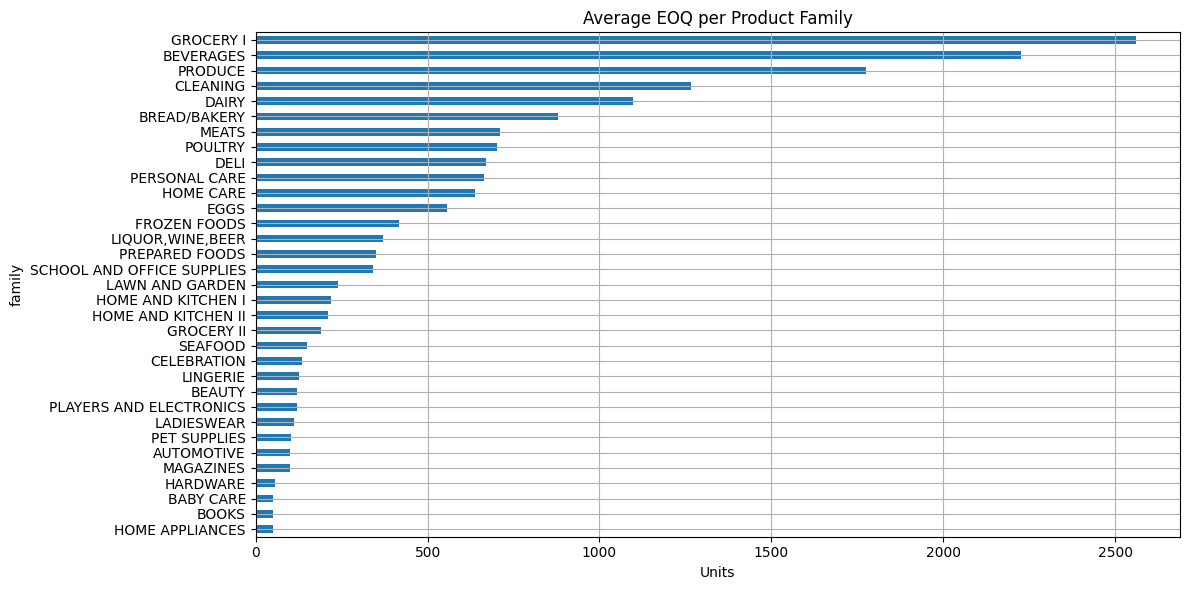

In [24]:
import matplotlib.pyplot as plt

# EOQ by category
plt.figure(figsize=(12, 6))
inventory_df.groupby('family')['EOQ'].mean().sort_values().plot(kind='barh')
plt.title("Average EOQ per Product Family")
plt.xlabel("Units")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
!C:\python\python.exe -m pip install streamlit


   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ------ --------------------------------- 1.6/10.1 MB 9.3 MB/s eta 0:00:01
   --------------- ------------------------ 3.9/10.1 MB 10.2 MB/s eta 0:00:01
   --------------------- ------------------ 5.5/10.1 MB 9.3 MB/s eta 0:00:01
   --------------------------------- ------ 8.4/10.1 MB 10.6 MB/s eta 0:00:01
   ---------------------------------------- 10.1/10.1 MB 10.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   ---------------------------------------- 731.2/731.2 kB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ------------- -------------------------- 2.4/6.9 MB 12.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.0/6.9 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------  6.8/6.9 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 6.9/6.9 MB 10.6 MB/s eta 0:00:00
   ----------

In [27]:
import streamlit as st
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
import matplotlib.pyplot as plt

In [28]:
st.set_page_config(page_title="📦 Supply Chain Optimizer", layout="wide")

st.title("📦 Supply Chain Forecasting + Inventory Optimization")

2025-07-09 01:12:31.052 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:31.053 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:31.182 
  command:

    streamlit run C:\Users\bhomi\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-09 01:12:31.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:31.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [29]:
# Sidebar
st.sidebar.title("Upload Your Data")
train_file = st.sidebar.file_uploader("Upload train.csv", type="csv")
test_file = st.sidebar.file_uploader("Upload test.csv", type="csv")
holiday_file = st.sidebar.file_uploader("Upload holidays_events.csv", type="csv")

2025-07-09 01:12:36.817 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.818 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:12:36.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [30]:
# Helper Functions
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

def calc_eoq(demand, setup_cost, holding_cost, cv):
    return np.sqrt((2 * demand * setup_cost / holding_cost) * (1 + cv**2 / 2))

def calc_safety_stock(service_level, std_dev, lead_time):
    z = norm.ppf(service_level)
    return z * std_dev * np.sqrt(lead_time)

In [31]:
# Main Logic
if train_file and test_file and holiday_file:
    # Load data
    train = pd.read_csv(train_file, parse_dates=['date'])
    test = pd.read_csv(test_file, parse_dates=['date'])
    holidays = pd.read_csv(holiday_file, parse_dates=['date'])

    # Filter holidays
    holidays = holidays[(holidays['transferred'] == False) & (holidays['locale'] == 'National')]
    holiday_dates = holidays['date'].unique()

    # Add holiday feature
    train["is_holiday"] = train["date"].isin(holiday_dates).astype(int)
    test["is_holiday"] = test["date"].isin(holiday_dates).astype(int)

    # Feature engineering
    train = create_features(train)
    test = create_features(test)

    # Encode category
    le = LabelEncoder()
    train['family_enc'] = le.fit_transform(train['family'])
    test['family_enc'] = le.transform(test['family'])

    # Lag features
    train = train.sort_values(['store_nbr', 'family', 'date'])
    train['lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
    train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
    train = train.dropna()

    # Train model
    features = ['onpromotion', 'is_holiday', 'dayofweek', 'month', 'lag_1', 'rolling_mean_7', 'family_enc']
    X = train[features]
    y = train['sales']

    X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.1)
    model = LGBMRegressor()
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)

    st.success(f"✅ Model MAE on Validation: {mean_absolute_error(y_val, val_pred):.2f}")

    # Prepare test set for prediction
    latest = train.groupby(['store_nbr', 'family']).last().reset_index()
    test = test.merge(latest[['store_nbr', 'family', 'lag_1', 'rolling_mean_7']], on=['store_nbr', 'family'], how='left')

    test['sales'] = model.predict(test[features])
    forecast = test[['store_nbr', 'family', 'date', 'sales']]

    st.subheader("🔮 Sample Forecast Results")
    st.dataframe(forecast.head(20))

    # Inventory Optimization
    inventory_plan = []

    for (store, family), group in test.groupby(['store_nbr', 'family']):
        predicted_demand = group['sales'].sum()
        std_dev = group['sales'].std() or 1
        eoq = calc_eoq(predicted_demand, setup_cost=100, holding_cost=2, cv=0.3)
        safety = calc_safety_stock(service_level=0.95, std_dev=std_dev, lead_time=7)

        inventory_plan.append({
            'store_nbr': store,
            'family': family,
            'forecasted_demand': round(predicted_demand, 2),
            'EOQ': round(eoq, 2),
            'Safety_Stock': round(safety, 2)
        })

    inventory_df = pd.DataFrame(inventory_plan)

    st.subheader("📦 Inventory Plan (EOQ & Safety Stock)")
    st.dataframe(inventory_df.head(20))

    # Download buttons
    st.download_button("📥 Download Forecast CSV", forecast.to_csv(index=False), file_name="submission.csv")
    st.download_button("📥 Download Inventory Plan CSV", inventory_df.to_csv(index=False), file_name="inventory_plan.csv")

    # Visualization
    st.subheader("📊 EOQ by Product Family")
    family_eoq = inventory_df.groupby("family")["EOQ"].mean().sort_values()
    fig, ax = plt.subplots(figsize=(12, 6))
    family_eoq.plot(kind='barh', ax=ax)
    plt.xlabel("EOQ")
    plt.title("Average EOQ by Product Family")
    st.pyplot(fig)

else:
    st.info("Please upload all 3 required CSV files from the dataset: `train.csv`, `test.csv`, and `holidays_events.csv`.")

2025-07-09 01:13:01.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:13:01.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-09 01:13:01.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [32]:
# Paste this in a cell inside supply.ipynb

streamlit_code = """
import streamlit as st
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
import matplotlib.pyplot as plt

st.set_page_config(page_title="📦 Supply Chain Optimizer", layout="wide")

st.title("📦 Supply Chain Forecasting + Inventory Optimization")

# Sidebar
st.sidebar.title("Upload Your Data")
train_file = st.sidebar.file_uploader("Upload train.csv", type="csv")
test_file = st.sidebar.file_uploader("Upload test.csv", type="csv")
holiday_file = st.sidebar.file_uploader("Upload holidays_events.csv", type="csv")

# Helper Functions
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

def calc_eoq(demand, setup_cost, holding_cost, cv):
    return np.sqrt((2 * demand * setup_cost / holding_cost) * (1 + cv**2 / 2))

def calc_safety_stock(service_level, std_dev, lead_time):
    z = norm.ppf(service_level)
    return z * std_dev * np.sqrt(lead_time)

# Main Logic
if train_file and test_file and holiday_file:
    # Load data
    train = pd.read_csv(train_file, parse_dates=['date'])
    test = pd.read_csv(test_file, parse_dates=['date'])
    holidays = pd.read_csv(holiday_file, parse_dates=['date'])

    # Filter holidays
    holidays = holidays[(holidays['transferred'] == False) & (holidays['locale'] == 'National')]
    holiday_dates = holidays['date'].unique()

    # Add holiday feature
    train["is_holiday"] = train["date"].isin(holiday_dates).astype(int)
    test["is_holiday"] = test["date"].isin(holiday_dates).astype(int)

    # Feature engineering
    train = create_features(train)
    test = create_features(test)

    # Encode category
    le = LabelEncoder()
    train['family_enc'] = le.fit_transform(train['family'])
    test['family_enc'] = le.transform(test['family'])

    # Lag features
    train = train.sort_values(['store_nbr', 'family', 'date'])
    train['lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
    train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
    train = train.dropna()

    # Train model
    features = ['onpromotion', 'is_holiday', 'dayofweek', 'month', 'lag_1', 'rolling_mean_7', 'family_enc']
    X = train[features]
    y = train['sales']

    X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.1)
    model = LGBMRegressor()
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)

    st.success(f"✅ Model MAE on Validation: {mean_absolute_error(y_val, val_pred):.2f}")

    # Prepare test set for prediction
    latest = train.groupby(['store_nbr', 'family']).last().reset_index()
    test = test.merge(latest[['store_nbr', 'family', 'lag_1', 'rolling_mean_7']], on=['store_nbr', 'family'], how='left')

    test['sales'] = model.predict(test[features])
    forecast = test[['store_nbr', 'family', 'date', 'sales']]

    st.subheader("🔮 Sample Forecast Results")
    st.dataframe(forecast.head(20))

    # Inventory Optimization
    inventory_plan = []

    for (store, family), group in test.groupby(['store_nbr', 'family']):
        predicted_demand = group['sales'].sum()
        std_dev = group['sales'].std() or 1
        eoq = calc_eoq(predicted_demand, setup_cost=100, holding_cost=2, cv=0.3)
        safety = calc_safety_stock(service_level=0.95, std_dev=std_dev, lead_time=7)

        inventory_plan.append({
            'store_nbr': store,
            'family': family,
            'forecasted_demand': round(predicted_demand, 2),
            'EOQ': round(eoq, 2),
            'Safety_Stock': round(safety, 2)
        })

    inventory_df = pd.DataFrame(inventory_plan)

    st.subheader("📦 Inventory Plan (EOQ & Safety Stock)")
    st.dataframe(inventory_df.head(20))

    # Download buttons
    st.download_button("📥 Download Forecast CSV", forecast.to_csv(index=False), file_name="submission.csv")
    st.download_button("📥 Download Inventory Plan CSV", inventory_df.to_csv(index=False), file_name="inventory_plan.csv")

    # Visualization
    st.subheader("📊 EOQ by Product Family")
    family_eoq = inventory_df.groupby("family")["EOQ"].mean().sort_values()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, 6))
    family_eoq.plot(kind='barh', ax=ax)
    plt.xlabel("EOQ")
    plt.title("Average EOQ by Product Family")
    st.pyplot(fig)

else:
    st.info("Please upload all 3 required CSV files from the dataset: `train.csv`, `test.csv`, and `holidays_events.csv`.")
"""

# Save to app.py
with open("app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("✅ app.py has been created successfully.")


✅ app.py has been created successfully.


In [ ]:
!streamlit run app.py
